In [5]:
import pandas as pd # 0.21.0
import numpy as np
from functools import reduce
from time import time

import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [6]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

### NOTE: 
1. Added 190 features utilizing talib library. All are technical based indicators.
2. Trying to overfit to train first before working on variance problem (train vs. test).
3. Random Forest and XGBoost result in sub 50% accuracy, while depending on training epochs I can get LSTM to 60% (not validated though.
4. When normalizing, I took the mean and standard deviation for the given time step. (e.g. if time step is 20 then using 20 past days mean and standard deviation.

In [7]:
import talib as ta
ta.get_function_groups

<function talib.get_function_groups>

In [8]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [71]:
def get_features(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    log_ret_df = get_log_returns(df['Adj. Close'])
    # Handle look ahead-bias
    shifted_df = df.shift(1)
    
    momentum_df = get_momentum_indicators(shifted_df)
    hist_vol_df = get_hist_vol_indicators(shifted_df)
    pattern_df = get_pattern_recognition_indicators(shifted_df)
    cycle_df = get_cycle_indicators(shifted_df)
    overlap_df = get_overlap_indicators(shifted_df)
    ohlc_df = get_ohlc_features(df)
    
    dfs = [shifted_df, log_ret_df, momentum_df, hist_vol_df, pattern_df, cycle_df, overlap_df, ohlc_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs).dropna()
    return df_final

def get_log_returns(df):
    df_log =  pd.DataFrame(np.log(df/df.shift(1))).dropna()
    df_log = df_log.rename(index=str, columns={"Adj. Close": "log_ret"})
    return df_log

def get_momentum_indicators(df, days = [7,14,28, 56]):
    # http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    momentum = dict()
    for t in days:
        momentum['adx_{}'.format(t)] = ta.ADX(high, low, close, timeperiod=t)
        momentum['adxr_{}'.format(t)] = ta.ADXR(high, low, close, timeperiod=t)
        momentum['aroondown_{}'.format(t)], momentum['aroonup_{}'.format(t)] = ta.AROON(high, low, timeperiod=t)
        momentum['aroon_{}'.format(t)] = ta.AROONOSC(high, low, timeperiod=t)
        momentum['rsi_{}'.format(t)] = ta.RSI(close, timeperiod=t)
        momentum['mom_{}'.format(t)] = ta.MOM(close, timeperiod=t)
        momentum['roc_{}'.format(t)] = ta.ROC(close, timeperiod=t)
        momentum['willr_{}'.format(t)] = ta.WILLR(high, low, close, timeperiod=t)
        momentum['trix_{}'.format(t)] = ta.TRIX(close, timeperiod=t)
        
        
    momentum['apo'] = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['macd'], momentum['macdsignal'], momentum['macdhist'] = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    momentum['ppo'] = ta.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['slowk'], momentum['slowd'] = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    momentum['fastk'], momentum['fastd'] = ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    momentum['fastkrsi'], momentum['fastdrsi'] = ta.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    
    df = pd.DataFrame.from_dict(momentum)
    df = df.set_index(df_index)
    return df

def get_hist_vol_indicators(df, days = [7,14,28, 56]):
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    hist_vol = dict()
    for t in days:
        hist_vol['atr_{}'.format(t)] = ta.ATR(high, low, close, timeperiod=t)
        hist_vol['natr_{}'.format(t)] = ta.NATR(high, low, close, timeperiod=t)
        hist_vol['std_{}'.format(t)] = ta.STDDEV(close, timeperiod=t, nbdev=1)
        hist_vol['var_{}'.format(t)] = ta.VAR(close, timeperiod=t, nbdev=1)
        hist_vol['linreg_{}'.format(t)] = ta.LINEARREG(close, timeperiod=t)

        
    hist_vol['trange'] = ta.TRANGE(high, low, close)
    df = pd.DataFrame.from_dict(hist_vol)
    df = df.set_index(df_index)
    return df

def get_pattern_recognition_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    patterns = dict()
    patterns['CDL2CROWS'] = ta.CDL2CROWS(open, high, low, close)
    patterns['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(open, high, low, close)
    patterns['CDL3INSIDE'] = ta.CDL3INSIDE(open, high, low, close)
    patterns['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(open, high, low, close)
    patterns['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(open, high, low, close)
    patterns['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(open, high, low, close)
    patterns['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(open, high, low, close)
    patterns['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(open, high, low, close, penetration=0)
    patterns['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(open, high, low, close)
    patterns['CDLBELTHOLD'] = ta.CDLBELTHOLD(open, high, low, close)
    patterns['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(open, high, low, close)
    patterns['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(open, high, low, close)
    patterns['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(open, high, low, close)
    patterns['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(open, high, low, close)
    patterns['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
    patterns['CDLDOJI'] = ta.CDLDOJI(open, high, low, close)
    patterns['CDLDOJISTAR'] = ta.CDLDOJISTAR(open, high, low, close)
    patterns['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(open, high, low, close)
    patterns['CDLENGULFING'] = ta.CDLENGULFING(open, high, low, close)
    patterns['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(open, high, low, close)
    patterns['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(open, high, low, close)
    patterns['CDLHAMMER'] = ta.CDLHAMMER(open, high, low, close)
    patterns['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(open, high, low, close)
    patterns['CDLHARAMI'] = ta.CDLHARAMI(open, high, low, close)
    patterns['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(open, high, low, close)
    patterns['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(open, high, low, close)
    patterns['CDLHIKKAKE'] = ta.CDLHIKKAKE(open, high, low, close)
    patterns['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(open, high, low, close)
    patterns['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(open, high, low, close)
    patterns['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(open, high, low, close)
    patterns['CDLINNECK'] = ta.CDLINNECK(open, high, low, close)
    patterns['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(open, high, low, close)
    patterns['CDLKICKING'] = ta.CDLKICKING(open, high, low, close)
    patterns['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(open, high, low, close)
    patterns['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(open, high, low, close)
    patterns['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(open, high, low, close)
    patterns['CDLLONGLINE'] = ta.CDLLONGLINE(open, high, low, close)
    patterns['CDLMARUBOZU'] = ta.CDLMARUBOZU(open, high, low, close)
    patterns['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(open, high, low, close)
    patterns['CDLMATHOLD'] = ta.CDLMATHOLD(open, high, low, close, penetration=0)
    patterns['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLONNECK'] = ta.CDLONNECK(open, high, low, close)
    patterns['CDLPIERCING'] = ta.CDLPIERCING(open, high, low, close)
    patterns['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(open, high, low, close)
    patterns['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(open, high, low, close)
    patterns['CDLSEPARATINGLINE'] = ta.CDLSEPARATINGLINES(open, high, low, close)
    patterns['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(open, high, low, close)
    patterns['CDLSHORTLINE'] = ta.CDLSHORTLINE(open, high, low, close)
    patterns['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(open, high, low, close)
    patterns['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(open, high, low, close)
    patterns['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(open, high, low, close)
    patterns['CDLTAKURI'] = ta.CDLTAKURI(open, high, low, close)
    patterns['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(open, high, low, close)
    patterns['CDLTHRUSTING'] = ta.CDLTHRUSTING(open, high, low, close)
    patterns['CDLTRISTAR'] = ta.CDLTRISTAR(open, high, low, close)
    patterns['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(open, high, low, close)
    patterns['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(open, high, low, close)
    patterns['DLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(open, high, low, close)
    df = pd.DataFrame.from_dict(patterns)
    df = df.set_index(df_index)
    return df


def get_cycle_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    cycle = dict()
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['HT_DCPHASE'] = ta.HT_DCPHASE(close)
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['inphase'], cycle['quadrature'] = ta.HT_PHASOR(close)
    cycle['sine'], cycle['leadsine'] = ta.HT_SINE(close)
    cycle['integer'] = ta.HT_TRENDMODE(close)
    
    df = pd.DataFrame.from_dict(cycle)
    df = df.set_index(df_index)
    return df

def get_overlap_indicators(df, days = [7, 14, 28, 56]):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    overlap = dict()
    for t in days:
        bbands = ta.BBANDS(close, timeperiod=t, nbdevup=2, nbdevdn=2, matype=0)
        overlap['bb_upperband_{}'.format(t)], overlap['bb_middleband_{}'.format(t)], overlap['bb_lowerband_{}'.format(t)] = bbands
            
        overlap['DEMA_{}'.format(t)] = ta.DEMA(close, timeperiod=t)
        overlap['EMA_{}'.format(t)] = ta.EMA(close, timeperiod=t)
        
        overlap['KAMA_{}'.format(t)] = ta.KAMA(close, timeperiod=t)
        overlap['MA_{}'.format(t)] = ta.MA(close, timeperiod=t, matype=0)
        overlap['MIDPOINT_{}'.format(t)] = ta.MIDPOINT(close, timeperiod=t)
        overlap['MIDPRICE_{}'.format(t)] = ta.MIDPRICE(high, low, timeperiod=t)
        overlap['SMA_{}'.format(t)] = ta.SMA(close, timeperiod=t)
        overlap['T3_{}'.format(t)] = ta.T3(close, timeperiod=t, vfactor=0)
        overlap['TEMA(_{}'.format(t)] = ta.TEMA(close, timeperiod=t)
        overlap['TRIMA_{}'.format(t)] = ta.TRIMA(close, timeperiod=t)
        overlap['WMA_{}'.format(t)] = ta.WMA(close, timeperiod=t)
        
        
        overlap['HT_TRENDLINE'] = ta.HT_TRENDLINE(close)
        overlap['mama'], overlap['fama'] = ta.MAMA(close, fastlimit=0.9, slowlimit=0.1)
        overlap['SAR'] = ta.SAR(high, low, acceleration=0, maximum=0)
        overlap['SAREXT'] = ta.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    
    df = pd.DataFrame.from_dict(overlap)
    df = df.set_index(df_index)
    return df

def get_ohlc_features(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    olhc = dict()
    olhc['hilo_diff'] = high - low
    olhc['opcl_diff'] = close - open
    
    df = pd.DataFrame.from_dict(olhc)
    df = df.set_index(df_index)
    return df
    
    

In [98]:
df = get_features("AAPL", "09-01-09", "17-10-17")

In [99]:
print("Any Nans: {}".format(df.isnull().values.any()))
print("Nan count: {}".format(df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [100]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Ex-Dividend']
del df['Split Ratio']



In [101]:
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 210
Categorical features : 0


### Date, Time features

In [102]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,Date,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,-0.010473,45.136260,29.777463,18.923556,...,35.284471,35.121029,34.914997,33.579632,33.771089,1.209316,0.379759,2010-05-05,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,-0.038772,42.009384,29.185824,18.886902,...,35.253894,35.204408,34.702076,33.312041,32.984985,7.582322,-0.974136,2010-05-06,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.043109,42.763943,29.243772,18.802612,...,35.192517,35.227971,35.140158,33.288996,32.851142,2.745058,-1.008834,2010-05-07,5,7


In [103]:
del df['Date']
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_14,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,-0.010473,45.136260,29.777463,18.923556,...,35.576850,35.284471,35.121029,34.914997,33.579632,33.771089,1.209316,0.379759,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,-0.038772,42.009384,29.185824,18.886902,...,35.530594,35.253894,35.204408,34.702076,33.312041,32.984985,7.582322,-0.974136,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.043109,42.763943,29.243772,18.802612,...,35.553269,35.192517,35.227971,35.140158,33.288996,32.851142,2.745058,-1.008834,5,7


### Create lagged features

In [104]:
steps = 20
lags_df = (pd.concat(
    [df.log_ret.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_ret'] + ['log_ret_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_ret'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [105]:

final_df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,log_ret_L10,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-02,31302600.0,33.373784,34.176997,33.279969,33.520290,219118200.0,0.011891,35.027386,25.911122,16.738082,...,-0.007343,0.001575,-0.017729,-0.014334,0.021481,0.009912,0.074056,-0.043109,-0.038772,-0.010473
2010-06-03,24591000.0,33.997077,34.030491,33.456676,33.921254,172137000.0,-0.003149,33.270956,25.407941,16.559237,...,-0.016058,-0.007343,0.001575,-0.017729,-0.014334,0.021481,0.009912,0.074056,-0.043109,-0.038772
2010-06-04,23218100.0,34.079326,34.126876,33.466315,33.814587,162526700.0,-0.027569,31.553821,24.898773,16.376580,...,-0.043537,-0.016058,-0.007343,0.001575,-0.017729,-0.014334,0.021481,0.009912,0.074056,-0.043109


In [106]:
print("Any Nans: {}".format(final_df.isnull().values.any()))
print("Nan count: {}".format(final_df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [107]:
# Classify data.
# Up if greater than 1%, nuetral, down if less than -1%
final_df["y"] = final_df.apply(
    lambda x: 1 if ((np.exp(x['log_ret']) - 1) > 0.01) else -1 if (np.exp(x['log_ret']) - 1) < -0.01 else 0 ,
    axis=1
)


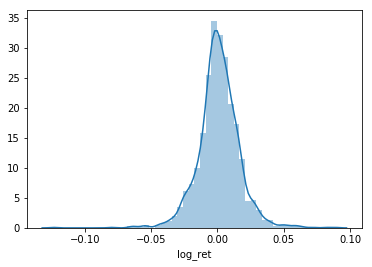

In [108]:
import seaborn as sns
%matplotlib inline
sns.distplot(np.exp(final_df['log_ret'])-1)

In [109]:
# Remove log_ret which can lead to look ahead effects
del final_df["log_ret"]

In [114]:
print("shape: {}".format(final_df.shape))


shape: (1858, 231)


In [115]:
train_size = int(final_df.shape[0]*0.9)

### Split into train and test

In [116]:
train, test = final_df.iloc[:train_size], final_df.iloc[train_size:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (1672, 231)
Test shape: (186, 231)


In [117]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)
train_dummy = pd.read_csv('train_data.csv')
test_dummy = pd.read_csv('test_data.csv')

In [217]:
train.head(3).T

Date,2010-06-02 00:00:00,2010-06-03 00:00:00,2010-06-04 00:00:00
Volume,3.130260e+07,2.459100e+07,2.321810e+07
Adj. Open,3.337378e+01,3.399708e+01,3.407933e+01
Adj. High,3.417700e+01,3.403049e+01,3.412688e+01
Adj. Low,3.327997e+01,3.345668e+01,3.346631e+01
Adj. Close,3.352029e+01,3.392125e+01,3.381459e+01
Adj. Volume,2.191182e+08,1.721370e+08,1.625267e+08
adx_14,3.502739e+01,3.327096e+01,3.155382e+01
adx_28,2.591112e+01,2.540794e+01,2.489877e+01
adx_7,3.326602e+01,2.987204e+01,2.728327e+01
adxr_14,3.805333e+01,3.670401e+01,3.562177e+01


### Test if normalization is working as expected.

In [218]:

train_temp = train[['Volume','Adj. Open']].iloc[0:3]
train_temp 

,Volume,Adj. Open
Date,,
2010-06-02,31302600.0,33.373784
2010-06-03,24591000.0,33.997077
2010-06-04,23218100.0,34.079326


In [219]:
mean_temp = train_temp.apply(np.mean,axis=0)
std_temp = train_temp.apply(np.std,axis=0)
(train_temp - mean_temp)/std_temp

,Volume,Adj. Open
Date,,
2010-06-02,1.396296,-1.406156
2010-06-03,-0.503809,0.572526
2010-06-04,-0.892487,0.833630


In [220]:
(train_temp.Volume - np.mean(train_temp.Volume))/np.std(train_temp.Volume)

Date
2010-06-02    1.396296
2010-06-03   -0.503809
2010-06-04   -0.892487
Name: Volume, dtype: float64

In [221]:
mean = train.apply(np.mean,axis=0)
std = train.apply(np.std,axis=0)
norm = (train - mean)/std

In [222]:
norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Volume,1672.0,0.000000e+00,1.000299,-1.117884,-0.723855,-0.306341,0.441655,7.893036
Adj. Open,1672.0,-2.719781e-16,1.000299,-1.742043,-0.874405,-0.116445,0.947338,1.885725
Adj. High,1672.0,3.399726e-16,1.000299,-1.732274,-0.878212,-0.116244,0.947149,1.848446
Adj. Low,1672.0,-2.039836e-16,1.000299,-1.739880,-0.871538,-0.119940,0.942139,1.839194
Adj. Close,1672.0,4.759616e-16,1.000299,-1.732144,-0.870636,-0.112414,0.944924,1.837770
Adj. Volume,1672.0,1.359890e-16,1.000299,-1.380383,-0.751427,-0.237421,0.441186,6.763029
adx_14,1672.0,2.039836e-16,1.000299,-1.694314,-0.727381,-0.189239,0.561600,4.024831
adx_28,1672.0,-1.699863e-16,1.000299,-1.582763,-0.708663,-0.195681,0.525758,3.737684
adx_7,1672.0,9.774212e-17,1.000299,-1.974519,-0.751602,-0.169994,0.562916,3.739946
adxr_14,1672.0,-1.019918e-16,1.000299,-1.582677,-0.725208,-0.127191,0.515676,3.982851


### Assess distribution and statistics of data

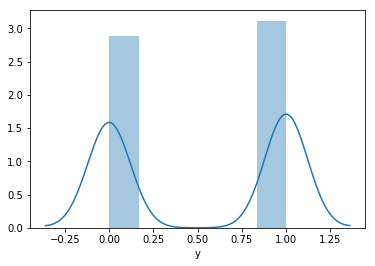

In [223]:
train_y_dummy = train_dummy.pop('y')
test_y_dummy = test_dummy.pop('y')
import seaborn as sns
%matplotlib inline
sns.distplot(train_y_dummy)

In [224]:
y_dummy.describe()

count    1672.000000
mean        0.519139
std         0.499783
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

### Train RandomForest classifier

In [225]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_dummy, train_y_dummy)
pred = rfc_model.predict(test_dummy)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


Accuracy for Random Forest Model: 42.47


In [226]:
xgbc = XGBClassifier()
xgbc.fit(train_dummy,  train_y_dummy)
pred = xgbc.predict(test_dummy)
print("Accuracy for XGB Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


Accuracy for XGB Model: 45.70


In [261]:
class SequenceDataset(Dataset):

    """
    Custom dataset to convert features to inputs of sequences.
    """

    def __init__(self, csv_file, root_dir, time_steps, transform=None):
        self._steps = time_steps
        self._transform = transform
        self._frames = pd.read_csv(os.path.join(root_dir, csv_file))
        
        self._y = self._frames.pop("y")
        self._X = self._frames

    def __len__(self):
        return len(self._frames.index) - self._steps

    def __getitem__(self, idx):
        index = idx + self._steps
        # Normalize over sequence (TODO: Find a better way to handle)
        X = self._X.iloc[index-self._steps:index]
        X_mean = X.apply(np.mean,axis=0)
        X_std = X.apply(np.std,axis=0)
        X_normalized = (X - X_mean)/(X_std+1e-10)
        sequence = torch.from_numpy(X_normalized.as_matrix())
        
        label = torch.from_numpy(np.array([self._y.iloc[index]]))
        return {'sequence': sequence, 'label': label}
    
    

In [262]:
train_data = SequenceDataset('train_data.csv','.',25)
test_data = SequenceDataset('test_data.csv','.',25)

train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)



In [298]:
class SimpleLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, batch_size, steps):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.steps = steps
        
        # Try preprocess with FC layer
        # https://danijar.com/tips-for-training-recurrent-neural-networks/
        self.fc_pre = nn.Linear(self.input_size, 100)
        self.rnn = nn.LSTM(100, hidden_size=self.hidden_size, num_layers=2, dropout=0.5, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(100, 2),
            nn.Sigmoid()
        )
        
        """
        # Consider learning the hidden initialization
        self.h_0 = nn.Parameter(
            torch.randn(2, self.batch_size, self.hidden_size).type(torch.FloatTensor),
            requires_grad=True
        )
        self.c_0 = nn.Parameter(
            torch.randn(2, self.batch_size, self.hidden_size).type(torch.FloatTensor),
            requires_grad=True
        )
        """
        

    def forward(self, x, train=True):
        out = self.fc_pre(x)
        # hidden,cell init to 0 as default
        out, _ = self.rnn(out)
        # We want the out of the last step (batch, step, out)
        return self.fc(out[:,-1,:])

In [302]:
model = SimpleLSTM(input_size=190, hidden_size=100, batch_size=1, steps=25)
optimizer =  torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [303]:
model.train()
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = []
    for i, batch in enumerate(train_loader):
        inputs = batch['sequence']
        labels = batch['label']
        
        inputs, labels = Variable(inputs.type(torch.FloatTensor)), Variable(labels.type(torch.LongTensor).squeeze(1))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.75)
        
        optimizer.step()
    

        # print statistics
        running_loss.append(loss.data[0])
    
    print('Epoch: {}  loss: {}'.format(
          epoch + 1, np.mean(np.array(running_loss))))


print('Finished Training')

Epoch: 1  loss: 0.6958295959158239
Epoch: 2  loss: 0.6942140166514847
Epoch: 3  loss: 0.6937011241659513
Epoch: 4  loss: 0.6938326560191552
Epoch: 5  loss: 0.6941930731644251
Epoch: 6  loss: 0.6932720767235713
Epoch: 7  loss: 0.6922108060168582
Epoch: 8  loss: 0.6896464317114193
Epoch: 9  loss: 0.6911289207343267
Epoch: 10  loss: 0.6860594617176866
Epoch: 11  loss: 0.6862300138583528
Epoch: 12  loss: 0.6812323353184884
Epoch: 13  loss: 0.6835873212572583
Epoch: 14  loss: 0.6777884924165682
Epoch: 15  loss: 0.6745959370875981
Epoch: 16  loss: 0.6726331988210452
Epoch: 17  loss: 0.6662404500106355
Epoch: 18  loss: 0.6589502366876052
Epoch: 19  loss: 0.6683973884611472
Epoch: 20  loss: 0.662508056173921
Epoch: 21  loss: 0.6690953636104292
Epoch: 22  loss: 0.6600927540983803
Epoch: 23  loss: 0.6620521755311152
Epoch: 24  loss: 0.6603046579656271
Epoch: 25  loss: 0.6596484769635585
Epoch: 26  loss: 0.657396829627685
Epoch: 27  loss: 0.6551812899677263
Epoch: 28  loss: 0.6597774244650393
Epo

In [304]:
def evaluate(model, loader):
    model.eval()
    loss_sum = 0
    acc_sum = 0
    for i, batch in enumerate(loader):
        inputs = batch['sequence']
        labels = batch['label']
        inputs = Variable(inputs.type(torch.FloatTensor), volatile=True)
        labels = Variable(labels.type(torch.LongTensor).squeeze(1), volatile=True)
        
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss_sum += loss.data[0]

        predict = output.data.max(1)[1]
        acc = predict.eq(labels.data).cpu().sum()
        acc_sum += acc
    return loss_sum / len(loader), acc_sum / len(loader)

In [305]:
print(evaluate(model, test_loader))

(0.8051637870184383, 0.484472049689441)


In [207]:
score = Variable(torch.randn(10,2))
target = Variable((torch.rand(10)>0.5).long())
lfn1 = torch.nn.CrossEntropyLoss()
lfn2 = torch.nn.BCELoss()
print(lfn1(score,target), lfn2(torch.nn.functional.softmax(score)[:,1],target.float()))

Variable containing:
 0.8571
[torch.FloatTensor of size 1]
 Variable containing:
 0.8571
[torch.FloatTensor of size 1]



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [165]:
score

Variable containing:
-1.0032 -0.6803
 1.2381  0.0608
-0.8555  0.6880
 0.1313 -1.2839
-0.4654 -0.2737
-0.7864  0.7487
 1.4117  0.9339
 1.9578 -0.0274
-1.0772  2.5011
 0.2887 -0.4335
[torch.FloatTensor of size 10x2]

In [166]:
target

Variable containing:
 0
 1
 0
 1
 0
 1
 1
 0
 1
 1
[torch.LongTensor of size 10]